# US Accident

## Contexte

Nous constatons qu'il y a beaucoup d'accidents de voiture dans le monde. Les Etats-Unis n'échappe pas à la règle avec plusieurs milliers d'accidents dans le monde. Ainsi, nous allons nous poser 2 questions :
    <ul>
    <li>Quelles sont les régions les plus touchées par les accidents de voitures</li>
    <li>En cas d'accidents, quelles s'étaient les gravitées des accidents</li>
    </ul>
    
Nous allons égalements chercher à comprendre quelles sont les causes de ces accidents.

## Liens utiles

Telechargement de la liste des colonnes du Dataset :
   <a href="https://github.com/alphab2000x/python/blob/master/Master2/Projet5/Liste_des_colonnes.docx?raw=true">Liste_des_colonnes.docx</a>
    
Rapport :

## Import

In [264]:
import seaborn as sns;
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import cross_val_score;
from sklearn.preprocessing import LabelEncoder;
from sklearn.ensemble import RandomForestClassifier

# pipeline elements
from sklearn.decomposition import PCA # PCA = Principal Component Analysis
from sklearn.neighbors import KNeighborsClassifier as KNN 

# pipeline materiaux
from sklearn.pipeline import Pipeline # PCA = Principal Component Analysis
from sklearn.model_selection import GridSearchCV

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle
from sklearn.ensemble import GradientBoostingClassifier


## Fonction

In [265]:
# Créer une mesure de performance

def accuracy(preds, target):
    M = target.shape[0] # Nombre d'exemple
    total_correctes = (preds == target).sum()
    accuracy = total_correctes / M
    return accuracy

In [266]:
# Afficher la matrice de confusion

def show_cm(cm, labels):
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

## Collecte de données

Nous allons étudier un dataset qui regroupent un enssemble d'accidents de voitures ayant eu lieu aux états-unis, soit dans 49 états. Les données ont été récoltées entre 2016 et 2020. Initialement, le dataset faisait environ 3500000 lignes mais étant données sa taille, il a été décider de la réduire afin de ne pas réduire les performances de calculs de nos algorithmes. 

In [267]:
# On récupère notre Dataset et la stocke dans une variable

accident = pd.read_csv('data/US_Accidents_June20_mini.csv')

In [268]:
accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 50 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             100000 non-null  int64  
 1   ID                     100000 non-null  object 
 2   Source                 100000 non-null  object 
 3   TMC                    70472 non-null   float64
 4   Severity               100000 non-null  int64  
 5   Start_Time             100000 non-null  object 
 6   End_Time               100000 non-null  object 
 7   Start_Lat              100000 non-null  float64
 8   Start_Lng              100000 non-null  float64
 9   End_Lat                29528 non-null   float64
 10  End_Lng                29528 non-null   float64
 11  Distance(mi)           100000 non-null  float64
 12  Description            100000 non-null  object 
 13  Number                 35363 non-null   float64
 14  Street                 100000 non-nul

In [269]:
accident.head()

,Unnamed: 0,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,1901733,A-1901773,MapQuest,201.0,3,2018-05-20 12:33:29,2018-05-20 13:03:01,30.266512,-82.753860,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
1,2923127,A-2923261,Bing,NaN,3,2020-04-19 01:54:45,2020-04-19 02:24:45,38.367280,-90.384540,38.36728,...,False,False,False,False,False,False,Night,Night,Night,Night
2,323307,A-323310,MapQuest,201.0,2,2017-02-08 12:29:23,2017-02-08 12:59:01,34.000233,-84.067162,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
3,820712,A-820738,MapQuest,201.0,2,2019-10-15 09:28:51,2019-10-15 10:28:40,35.895634,-78.616295,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
4,2084795,A-2084835,MapQuest,201.0,2,2018-02-18 11:16:29,2018-02-18 11:45:23,36.679970,-78.176910,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day


## Feature Engineering

Nous allons dans cette partie définir les colonnes/features et la target puis isoler les features de target.

In [270]:
# On supprime les colonnes qui nous intéressent pas

accident = accident.drop(['ID'],axis=1)
accident = accident.drop(['Start_Lat'],axis=1)
accident = accident.drop(['Start_Lng'],axis=1)
accident = accident.drop(['End_Lat'],axis=1)
accident = accident.drop(['End_Lng'],axis=1)
accident = accident.drop(['Description'],axis=1)
accident = accident.drop(['Number'],axis=1)
accident = accident.drop(['Street'],axis=1)
accident = accident.drop(['Side'],axis=1)
accident = accident.drop(['Zipcode'],axis=1)
accident = accident.drop(['Country'],axis=1)
accident = accident.drop(['Timezone'],axis=1)
accident = accident.drop(['Weather_Timestamp'],axis=1)
accident = accident.drop(['Wind_Direction'],axis=1)
accident = accident.drop(['Wind_Chill(F)'],axis=1)

In [271]:
# On enlève toutes les valeurs NaN

accident = accident.dropna(how='any')

In [272]:
# On conserve notre Dataset sans transformation

accidentNoTransform = accident.copy()

In [273]:
# On convertie les colonnes dans le type qui nous interessent

accident['Source'] = LabelEncoder().fit_transform(accident['Source'])

accident.TMC = accident['TMC'].astype('category').cat.codes

accident.City = accident['City'].astype('category').cat.codes

accident.State = accident['State'].astype('category').cat.codes

accident.County = accident['County'].astype('category').cat.codes

accident.Airport_Code = accident['Airport_Code'].astype('category').cat.codes

accident.Sunrise_Sunset =accident['Sunrise_Sunset'].astype('category').cat.codes 

accident.Weather_Condition = accident['Weather_Condition'].astype('category').cat.codes

accident.Nautical_Twilight = accident['Nautical_Twilight'].astype('category').cat.codes

accident.Astronomical_Twilight = accident['Astronomical_Twilight'].astype('category').cat.codes

accident.Civil_Twilight = accident['Civil_Twilight'].astype('category').cat.codes

accident['Amenity'] = LabelEncoder().fit_transform(accident['Amenity'])
accident['Bump'] = LabelEncoder().fit_transform(accident['Bump'])
accident['Crossing'] = LabelEncoder().fit_transform(accident['Crossing'])
accident['Give_Way'] = LabelEncoder().fit_transform(accident['Give_Way'])
accident['Junction'] = LabelEncoder().fit_transform(accident['Junction'])
accident['No_Exit'] = LabelEncoder().fit_transform(accident['No_Exit'])
accident['Railway'] = LabelEncoder().fit_transform(accident['Railway'])
accident['Roundabout'] = LabelEncoder().fit_transform(accident['Roundabout'])
accident['Station'] = LabelEncoder().fit_transform(accident['Station'])
accident['Stop'] = LabelEncoder().fit_transform(accident['Stop'])
accident['Traffic_Calming'] = LabelEncoder().fit_transform(accident['Traffic_Calming'])
accident['Traffic_Signal'] = LabelEncoder().fit_transform(accident['Traffic_Signal'])
accident['Turning_Loop'] = LabelEncoder().fit_transform(accident['Turning_Loop'])

In [274]:
# On va séparer notre target de nos colonnes

Y = accident['Severity'].astype('category').cat.codes # La target va être la gravité
X = accident.drop('Severity', axis='columns') # En fonction des critère environnant, on va essayer de prédir le niveau de gravité

In [275]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25482 entries, 3 to 99994
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             25482 non-null  int64  
 1   Source                 25482 non-null  int32  
 2   TMC                    25482 non-null  int8   
 3   Start_Time             25482 non-null  object 
 4   End_Time               25482 non-null  object 
 5   Distance(mi)           25482 non-null  float64
 6   City                   25482 non-null  int16  
 7   County                 25482 non-null  int16  
 8   State                  25482 non-null  int8   
 9   Airport_Code           25482 non-null  int16  
 10  Temperature(F)         25482 non-null  float64
 11  Humidity(%)            25482 non-null  float64
 12  Pressure(in)           25482 non-null  float64
 13  Visibility(mi)         25482 non-null  float64
 14  Wind_Speed(mph)        25482 non-null  float64
 15  Pr

In [276]:
# On convertie nos column date de type object en type date

X['Start_Time'] = pd.to_datetime(X['Start_Time'], 
 format = '%Y-%m-%d %H:%M:%S', 
 errors = 'coerce')
X['End_Time'] = pd.to_datetime(X['End_Time'], 
 format = '%Y-%m-%d %H:%M:%S', 
 errors = 'coerce')

In [277]:
# On créé une colonne pour chaque élément de nos dates de début d'accident

X['Start_Time_year'] = X['Start_Time'].dt.year
X['Start_Time_month'] = X['Start_Time'].dt.month
X['Start_Time_week'] = X['Start_Time'].dt.week
X['Start_Time_day'] = X['Start_Time'].dt.day
X['Start_Time_hour'] = X['Start_Time'].dt.hour
X['Start_Time_minute'] = X['Start_Time'].dt.minute
X['Start_Time_dayofweek'] = X['Start_Time'].dt.dayofweek

In [278]:
# On créé une colonne pour chaque élément de nos dates de fin d'accident

X['End_Time_year'] = X['End_Time'].dt.year
X['End_Time_month'] = X['End_Time'].dt.month
X['End_Time_week'] = X['End_Time'].dt.week
X['End_Time_day'] = X['End_Time'].dt.day
X['End_Time_hour'] = X['End_Time'].dt.hour
X['End_Time_minute'] = X['End_Time'].dt.minute
X['End_Time_dayofweek'] = X['End_Time'].dt.dayofweek

In [279]:
# Maintenant que l'on a créé nos colonnes, on supprime nos de base vue que l'on en a plus besoin

X = X.drop(['Start_Time'],axis=1)
X = X.drop(['End_Time'],axis=1)

In [280]:
# On enlève toutes les valeurs NaN

X = X.dropna(how='any')

In [281]:
X.shape, Y.shape

((25482, 46), (25482,))

## Affichage des accidents en fonction des états

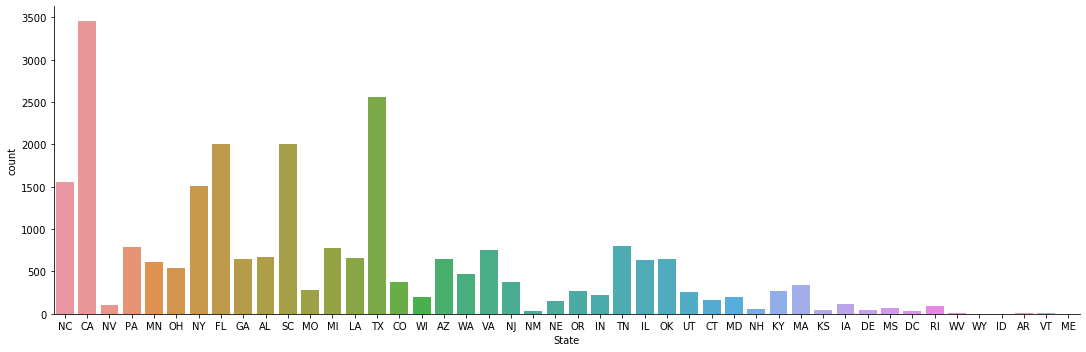

In [282]:
sns.catplot(x='State', kind='count',data=accidentNoTransform, height=5, aspect=3) 

Nous pouvons voir dans le diagramme ci-dessus que certains états ont beaucoup plus d'accidents que d'autres. En l'occurrence:
<ul>
    <li>La Californie (CA) avec 3458 accidents</li>
    <li>Le Texas (TX) avec 2557 accidents</li>
    <li>La Floride (FL) avec 2010 accidents</li>
    <li>La Caroline du Sud (SC) avec 2006 accidents</li>
    <li>La Caroline du Nord (NC) avec 1555 accidents</li>
    <li>New York (NY) avec 1507 accidents</li>
</ul>

ont beaucoup plus d'accidents que la plupart des autres pays.

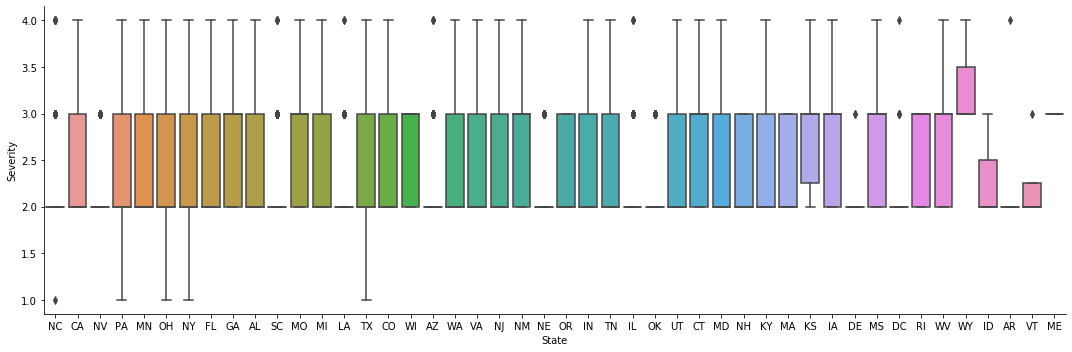

In [283]:
sns.catplot(x='State',y='Severity',kind="box",data=accidentNoTransform, height=5, aspect=3)

Comme on peut voir, la majorité des boites à moustaches on une severity minimal de 2 et maximum de 4. Quelques états ont une severity qui ne varie pas (ex: La caroline du sud (SC)). Enfin, des valeurs abbérantes viennent s'ajouter à notre boite à moustache. Celle-ci peuvent être causés par des villes qui ont beaucoup plus d'accidents graves que d'autres villes dans un même état.

## Affichage des villes avec le plus d'accidents

Voir les états les plus touchés par les accidents sont une bonne choses, mais nous voulons désormais voir si les villes les plus touchées par les accidents de voitures sont corrélé aux états les plus touchés.

In [284]:
# Notre objectif est de créer une colonne qui va nous permettre enssuite de faire un calcul afin d'avoir la somme 
#   des 10 villes les plus touchées.

df = accidentNoTransform
df['Accident'] = df['City'] # On créé notre nouvelle colonne
df

CityAccident = pd.DataFrame()            # On crée un nouveau dataframe
CityAccident['City'] = df['City']        # On ajoute à notre dataset la colonne City
CityAccident['Accident'] = 1             # On ajoute à notre dataset la valeur 1, cela nous permettra de faire la somme des city
total = CityAccident.groupby(by="City",as_index=False).sum().sort_values(by="Accident", ascending=False) # On groupe tout nos country en en fonction de la somme de nos class par ordre décroissant

print("50 villes les plus accidents par ordre décroissant :")
total.head(50)                                            # On affiche le total

50 villes les plus accidents par ordre décroissant :


,City,Accident
1309,Houston,755
484,Charlotte,724
119,Austin,581
669,Dallas,511
2332,Raleigh,508
2090,Oklahoma City,409
151,Baton Rouge,373
1929,Nashville,369
1624,Los Angeles,355
107,Atlanta,299


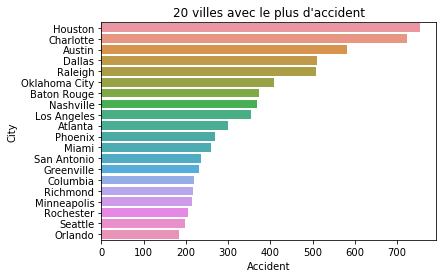

In [285]:
df = total.head(20)

sns.barplot(df['Accident'], df['City']).set_title("20 villes avec le plus d'accident");

Comme nous pouvons voir, les états avec le plus d'accidents ne possède pas forcemment les villes avec le plus d'accidents. Pour en citer quelques uns:
<ul>
    <li>Oklahoma City qui se situe dans l'Oklahoma (OK)</li>
    <li>Baton Rouge en Louisiane (LA)</li>
    <li>Nashville au Tennessee (TN)</li>
    <li>ou encore Atlanta en Georgie (GA)</li>
</ul>
qui sont des villes situé dans des états avec beaucoup moins d'accidents que les autres états vu au-dessus. 

Il faudra donc faire attention à ne pas se concentrer uniquement sur les états avec le plus d'accidents car si on s'interesse de plus près, ce n'est pas un facteur sufisant dans le cas où l'on chercherai à diminuer le nombres d'accidents. Il faudra cibler plus précisément les zones à risques.

## Etude et corrélation

Maintenant que l'on a une vision un peu plus précise des lieux le plus accidents, nous voulons voir si les zones les plus accidentés sont les zones avec le plus grands nombres d'accidents graves et quelles sont les causes d'un accidents graves. Pour cela, nous allons tout d'abord essayé de voir si certaines features ne sont pas corrélé avec notre target : "Severity".

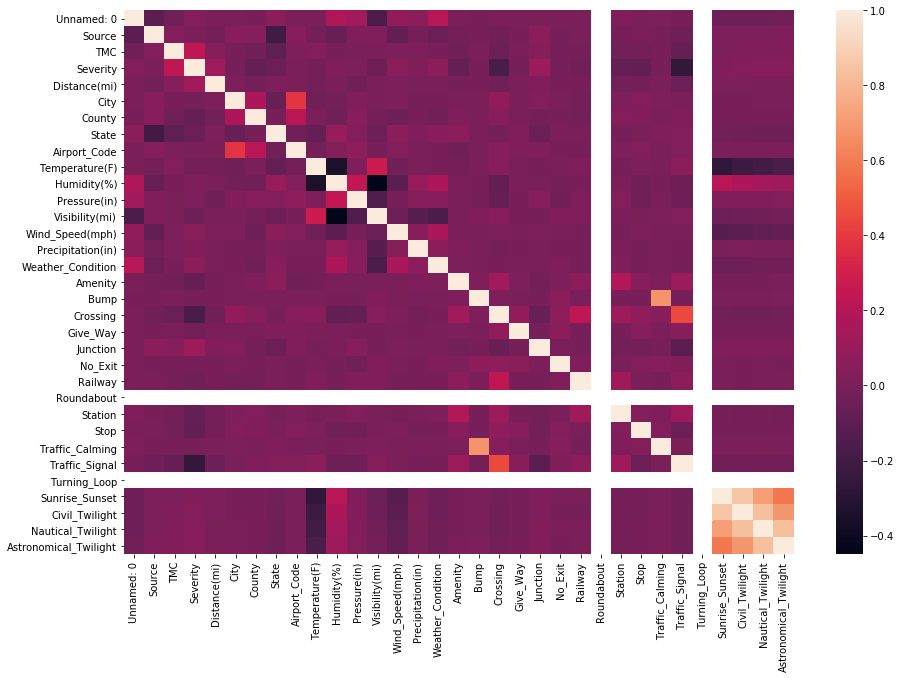

In [286]:
plt.figure(figsize=(15,10))
corr = sns.heatmap(accident.corr())

Nous pouvons voir que Severity est correlé avec 2 features:
<ul>
    <li>Traffic_Signal</li>
    <li>Crossing</li>
</ul>

Notre objectif est désormais de voir si ces features une belles est bien une incidence sur la severity.

##  Gravite des accidents en fonction de l'Etat

Avant d'étudier la corrélation entre nos features et target, nous allons chercher à savoir quelles sont les zones les plus touchés par les accidents graves.

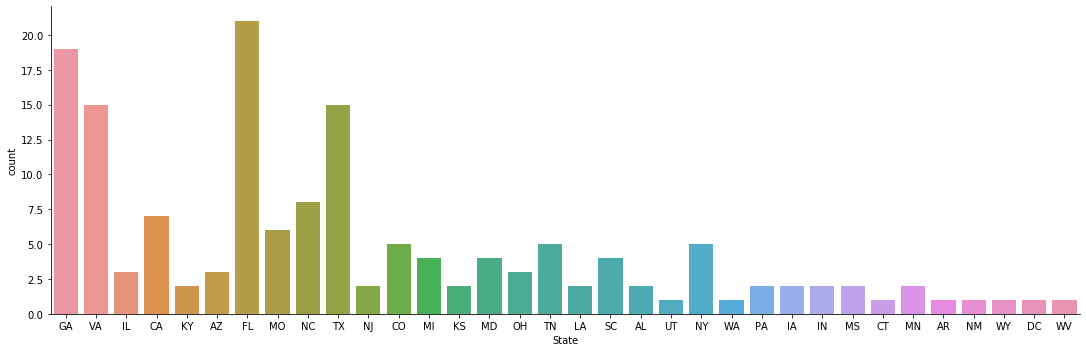

In [287]:
sns.catplot(x='State', kind='count',data=accidentNoTransform.query("(Severity == 4)"), height=5, aspect=3) 

On peut voir que ce graphique est très interessant car certaines zones comme:
<ul>
    <li>La Georgie (GA) avec 649 accidents</li>
    <li>La Virginie (VA) avec 752 accidents</li>
</ul>
qui on donc moins d'accidents que les d'autres états vu précédemment se retrouve avec beaucoup plus d'accidents graves et donc un impact fort sur le trafic.

## Entrainer un model

Nous souhaitons prédir la gravité d'un accident selon l'environnement qui entoure l'accident. Notre objectif va être de tester plusieurs algorithme afin de voir lequel est le plus efficace quand à l'obtention d'un résultat satisfaisant et accurate.

In [288]:
X_tr, X_te, Y_tr, Y_te = TTS(X, Y,              # features, target
                            stratify = Y,       # Va prendre une proportion aux hasard de valeurs différentes histoire de ne pas avoir des cas où l'on a que des même valeur
                            random_state=777,   # Sert à fixer le harsard pour ne pas avoir des résultat différents à chaque tests.
                            train_size=0.8)     # 50% de X_train et Y_train et 50% de Y_test et Y_test

### k-nearest neighbors

In [289]:
### Pipeline : Mise en place

pipeline_details = [('pca', PCA()),      # Algo de dimension reduction
                  ('knn', KNN())]        # Algo de machine learning 

pipeline = Pipeline(pipeline_details)

pipeline

Pipeline(steps=[('pca', PCA()), ('knn', KNeighborsClassifier())])

In [290]:
# Enssemble d'algorithme compliqué
# Param: Algo pca, permet de connaitre la valeur d'accuracy d'une valeur
#              d'un point, il va tester les colonne 1 par 1 afin de savoir
#              quelles sont les colonnes qui on le plus d'accuracy pour définir les colonnes 
#              les plus utile afin de diminué le nombre de features et donc d'augmenter 
#              les performances de calculs
#        Algo knn, de l'anglais k-nearest neighbors.
#              Pour estimer la sortie associée à une nouvelle entrée x, 
#              la méthode des k plus proches voisins consiste à prendre en compte (de façon identique) 
#              les k échantillons d'apprentissage dont l’entrée est la plus proche de la nouvelle entrée x,
#              selon une distance à définir.


# Paramètrer la Grid Search
hyperparameters = {}
hyperparameters['pca__n_components'] = list(range(1, 10+1, 1)) # Il va faire des test de 1 à 10 avec un pas de 1. Il s'agit de la liste des variable qui sera stocker dans n_component. Celle qui aura le meilleurs résultat sera testé.
hyperparameters['knn__n_neighbors'] = [1, 2, 3, 9, 21]         # Il va chercher avec 1 voisin jusqu'a 21 et celui qui aura la meilleurs accuracy sera selectionner

hyperparameters

{'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'knn__n_neighbors': [1, 2, 3, 9, 21]}

In [291]:
# Créer la grid search

hyperparameter_search = GridSearchCV(pipeline,            # Notre pipeline
                                    hyperparameters,      # Notre hyperparametre
                                    scoring='accuracy',   # Ce qui nous interesse, c'est l'accuracy
                                    cv=5)                 # cv est le nombre de model utilisé

In [292]:
hyperparameter_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 9, 21],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

In [293]:
hyperparameter_search.fit(X_tr, Y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 9, 21],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

### Recolter les résultats

In [294]:
hyperparameter_search.best_score_

0.6785871964679913

In [295]:
# On affiche les meilleurs parametrage afin d'obtenir la meilleurs accuracy

hyperparameter_search.best_params_

{'knn__n_neighbors': 21, 'pca__n_components': 1}

In [296]:
# On selectionne les meilleurs parametres

pca = PCA(n_components=1)
knn = KNN(n_neighbors=21,
         weights='uniform',
         leaf_size=3)

In [297]:
pca.fit(X_tr)

PCA(n_components=1)

In [298]:
X_tr_PCA = pca.transform(X_tr)  # On utilise en général le pca.transform pour optimiser avant le fit
X_te_PCA = pca.transform(X_te)

knn.fit(X_tr_PCA, Y_tr)
predictions = knn.predict(X_te_PCA) # On veut faire une prédiction par rapport à notre X_te_PCA

In [299]:
# On cherche à prédir X_tr_PCA par rapport à Y_tr

train_preds = knn.predict(X_tr_PCA)
"TRAIN ACCURACY: ", accuracy(train_preds, Y_tr)

('TRAIN ACCURACY: ', 0.7006131959774344)

In [300]:
# On chercher à prédir X_te_PCA par rapport à Y_te

"TEST ACCURACY: ", accuracy(predictions, Y_te)

('TEST ACCURACY: ', 0.6764763586423387)

Nous pouvons voir que nous avons une accuracy de 67 en test. Le résultat est intéressant mais pas satisfaisant car nous voulons pouvoir prédir avec un maximum de précision la gravité d'un accident afin de pouvoir, par la suite mieux cibler les zones qui seront touchées par des cas d'accidents avec une fortes "gravités" et donc, un plus fort impact sur la circulation.

### RandomForestClassifier

In [301]:
### Pipeline : Mise en place

pipeline_details = [('rfc', RandomForestClassifier())]        

pipeline = Pipeline(pipeline_details)

pipeline

Pipeline(steps=[('rfc', RandomForestClassifier())])

In [302]:
hyperparameters = {}
hyperparameters['rfc__random_state'] = [0, 60]         # Il va chercher avec 1 voisin jusqu'a 21 et celui qui aura la meilleurs accuracy sera selectionner

hyperparameters

{'rfc__random_state': [0, 60]}

In [303]:
# Créer la grid search

hyperparameter_search = GridSearchCV(pipeline,            # Notre pipeline
                                    hyperparameters,      # Notre hyperparametre
                                    scoring='accuracy',   # Ce qui nous interesse, c'est l'accuracy
                                    cv=5)                 # cv est le nombre de model utilisé

In [304]:
hyperparameter_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rfc', RandomForestClassifier())]),
             param_grid={'rfc__random_state': [0, 60]}, scoring='accuracy')

In [305]:
hyperparameter_search.fit(X_tr, Y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rfc', RandomForestClassifier())]),
             param_grid={'rfc__random_state': [0, 60]}, scoring='accuracy')

### Recolter les résultats

In [306]:
hyperparameter_search.best_score_

0.7500122639195487

In [307]:
# On affiche les meilleurs parametrage afin d'obtenir la meilleurs accuracy

hyperparameter_search.best_params_

{'rfc__random_state': 0}

In [308]:
# On selectionne les meilleurs parametres

clf = RandomForestClassifier(random_state=0,      # Lecture aléatoire des données
                            n_estimators=21,      # Il va diviser X_tr en plusieurs arbres
                            max_depth=7)          # Il va spliter/augmenter la profondeur des arbres

In [309]:
clf.fit(X_tr, Y_tr)

RandomForestClassifier(max_depth=7, n_estimators=21, random_state=0)

In [310]:
clf.predict(X_te)

array([2, 1, 1, ..., 1, 1, 1], dtype=int8)

In [311]:
pred_prob = clf.predict_proba(X_te)
pred_prob

array([[1.40475729e-03, 4.09334534e-01, 5.28600156e-01, 6.06605523e-02],
       [7.21589661e-05, 6.50880224e-01, 3.45377419e-01, 3.67019789e-03],
       [1.96043038e-04, 7.62088619e-01, 2.35295329e-01, 2.42000891e-03],
       ...,
       [3.51465958e-04, 5.33079517e-01, 4.62887468e-01, 3.68154951e-03],
       [7.56867716e-05, 8.32136472e-01, 1.66195165e-01, 1.59267675e-03],
       [2.22589171e-05, 8.18761431e-01, 1.79130849e-01, 2.08546058e-03]])

In [312]:
pred_probtr = clf.predict_proba(X_tr)

train_preds = clf.predict(X_tr)

"TRAIN ACCURACY: ", accuracy(train_preds, Y_tr)

('TRAIN ACCURACY: ', 0.7442727495707628)

In [313]:
# On cherche à prédir X_tr par rapport à Y_tr

predictions = clf.predict(X_te)
"TEST ACCURACY: ", accuracy(predictions, Y_te)

('TEST ACCURACY: ', 0.7290563076319404)

Nous pouvons voir que nous avons une accuracy de 72. Le résultat plus satisfaisant qu'avec le KNN. Afin de pouvoir prédir la gravité d'un accident, cette algorithme sera beaucoup plus intéressant à utiliesr.

### GradientBoostingClassifier

In [314]:
### Pipeline : Mise en place
#
# Gradient Boosting est un algorithme qui va assembler, unir en un tout 
# des modèles élaborés séquentiellement sur un échantillon d'apprentissage
# dont les poids des individus sont corrigés au fur et à mesure. En bref,
# il va construire plusieurs modèle et à chaque nouveau modèle,
# il va, en cas d'erreur donner un poid supplémentaire à ces
# erreurs et se corriger.

pipeline_details = [('grad', GradientBoostingClassifier())]        

pipeline = Pipeline(pipeline_details)

pipeline

Pipeline(steps=[('grad', GradientBoostingClassifier())])

In [315]:
hyperparameters = {}
hyperparameters['grad__random_state'] = [0, 60]          # Il va chercher avec 1 voisin jusqu'a 21 et celui qui aura la meilleurs accuracy sera selectionner

hyperparameters

{'grad__random_state': [0, 60]}

In [316]:
# Créer la grid search

hyperparameter_search = GridSearchCV(pipeline,            # Notre pipeline
                                    hyperparameters,      # Notre hyperparametre
                                    scoring='accuracy',   # Ce qui nous interesse, c'est l'accuracy
                                    cv=5)                 # cv est le nombre de model utilisé

In [317]:
hyperparameter_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('grad', GradientBoostingClassifier())]),
             param_grid={'grad__random_state': [0, 60]}, scoring='accuracy')

In [318]:
hyperparameter_search.fit(X_tr, Y_tr)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('grad', GradientBoostingClassifier())]),
             param_grid={'grad__random_state': [0, 60]}, scoring='accuracy')

### Recolter les résultats

In [319]:
hyperparameter_search.best_score_

0.7551140544518027

In [320]:
# On affiche les meilleurs parametrage afin d'obtenir la meilleurs accuracy

hyperparameter_search.best_params_

{'grad__random_state': 60}

In [321]:
grad = GradientBoostingClassifier(random_state=60,        # Lecture aléatoire des données
                                 n_estimators=40,         # Nombre d'étape (modèle), plus il y a de modèle, plus il apprendra
                                 max_depth=10)            # Profondeur de l'arborescence

In [322]:
grad.fit(X_tr, Y_tr) # On entraine notre sur le model

GradientBoostingClassifier(max_depth=10, n_estimators=40, random_state=60)

In [323]:
grad.predict(X_te)

array([2, 1, 1, ..., 1, 1, 1], dtype=int8)

In [330]:
pred_prob = grad.predict_proba(X_te)
pred_prob

array([[1.57596920e-05, 3.93430700e-01, 6.05273720e-01, 1.27982032e-03],
       [1.42045523e-05, 5.07438320e-01, 4.92114464e-01, 4.33010883e-04],
       [1.13619582e-05, 7.60591258e-01, 2.39043280e-01, 3.54100489e-04],
       ...,
       [1.31188433e-05, 6.16631646e-01, 3.82767306e-01, 5.87929244e-04],
       [4.18073920e-06, 9.79444248e-01, 2.04370565e-02, 1.14515224e-04],
       [5.85806535e-06, 9.62266666e-01, 3.75605385e-02, 1.66937666e-04]])

In [331]:
pred_probtr = grad.predict_proba(X_tr)

train_preds = grad.predict(X_tr)

"TRAIN ACCURACY: ", accuracy(train_preds, Y_tr)

('TRAIN ACCURACY: ', 0.9251410350748099)

In [332]:
# On cherche à prédir X_tr par rapport à Y_tr

predictions = grad.predict(X_te)
"TEST ACCURACY: ", accuracy(predictions, Y_te)

('TEST ACCURACY: ', 0.7696684324112223)

Cette fois-ci notre accuracy est de 76. Le résultats dans les tests est très accurate mais on a overfit car l'accuracy de notre train qui est de 92 est bien au-dessus de notre tests. Malgrès tout, l'algorithme est beaucoup plus intéressants que les 2 autres car l'avantage de cette algorithme est qu'il va chercher à corriger ces erreurs et plus il en fera, plus il sera performant.

## Features Importances

Nous allons essayer de detecter les features avec une forte importances afin de pouvoir déterminer quelles sont les features qui sont les plus influente pour l'obtention d'une bonne accuracy.

In [333]:
# La  features importances permet de connaitre l'importance d'une colonne
# par rapport aux autres colonnes.

X_tr_wo_index0 = X_tr.drop(['Unnamed: 0'],axis=1)
X_wo_index0 = X.drop(['Unnamed: 0'],axis=1)
clf.fit(X_tr_wo_index0, Y_tr)                       # On re-train nos valeurs
importance = clf.feature_importances_   
importance

array([0.00216844, 0.18450154, 0.09939984, 0.01697293, 0.03027319,
       0.04515247, 0.01575814, 0.00832191, 0.0104525 , 0.01258967,
       0.00827901, 0.00796831, 0.00904256, 0.01541678, 0.00063475,
       0.        , 0.06434389, 0.        , 0.02167671, 0.        ,
       0.00043282, 0.        , 0.00287184, 0.01114321, 0.        ,
       0.1874155 , 0.        , 0.00078743, 0.00122261, 0.00064588,
       0.00152319, 0.00659335, 0.00416182, 0.00695838, 0.00532152,
       0.02937946, 0.00945122, 0.04675422, 0.01167839, 0.00405005,
       0.00525213, 0.00619529, 0.04121834, 0.00828514, 0.05570555])

In [334]:
# On renomme nos colonnes

name = X_tr_wo_index0.columns.tolist()
colNumberList = list(range(len(X_tr_wo_index0.columns)))

In [335]:
# On renomme nos colonnes

name = X_tr_wo_index0.columns.tolist()
colNumberList = list(range(len(X_tr_wo_index0.columns)))

Features:

0  Source: (18.741550)
1  TMC: (18.450154)
2  Distance(mi): (9.939984)
3  City: (6.434389)
4  County: (5.570555)
5  State: (4.675422)
6  Airport_Code: (4.515247)
7  Temperature(F): (4.121834)
8  Humidity(%): (3.027319)
9  Pressure(in): (2.937946)
10  Visibility(mi): (2.167671)
11  Wind_Speed(mph): (1.697293)
12  Precipitation(in): (1.575814)
13  Weather_Condition: (1.541678)
14  Amenity: (1.258967)
15  Bump: (1.167839)
16  Crossing: (1.114321)
17  Give_Way: (1.045250)
18  Junction: (0.945122)
19  No_Exit: (0.904256)
20  Railway: (0.832191)
21  Roundabout: (0.828514)
22  Station: (0.827901)
23  Stop: (0.796831)
24  Traffic_Calming: (0.695838)
25  Traffic_Signal: (0.659335)
26  Turning_Loop: (0.619529)
27  Sunrise_Sunset: (0.532152)
28  Civil_Twilight: (0.525213)
29  Nautical_Twilight: (0.416182)
30  Astronomical_Twilight: (0.405005)
31  Start_Time_year: (0.287184)
32  Start_Time_month: (0.216844)
33  Start_Time_week: (0.152319)
34  Start_Time_day: (0.122261)
35  Start_Time_ho

<Figure size 432x288 with 0 Axes>

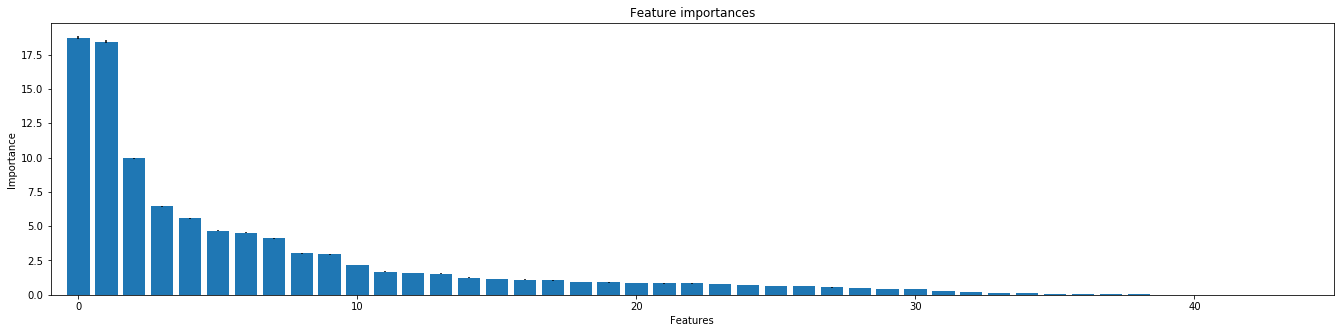

In [336]:
# On souhaite Afficher dans un graphique notre importance

std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importance)[::-1]

# Affichage de nos features avec leur pourcentage
print("Features:")
print()

for f in range(X_wo_index0.shape[1]):
    print("%d  %s: (%f)" % (f, X_tr_wo_index0.columns[f], importance[indices[f]]*100))

# Affichage de notre Features importance
plt.figure()
plt.subplots(figsize=(23,5))                                              #Taille de la figure
plt.title("Feature importances")
plt.xlabel('Features')
plt.ylabel('Importance')
plt.bar(colNumberList, importance[indices]*100, yerr=std[indices], align="center") # Valeur en X, Hauteur, Largeur, alignement
plt.xlim([-1, X_wo_index0.shape[1]])                                                # Limite de l'axe X
plt.show()

Le graphique ci-dessus nous montrent que certaines colonnes sont beaucoup plus importantes que d'autres. En l'occurence, les colonnes qui ont le pourcentage le plus grand sont beaucoup plus nécéssaire que celle qui on un pourcentage bas afin d'avoir un résultat une accuracy précise.

## Confusion matrix

In [337]:
X_te.shape, Y_te.shape, X_tr.shape, Y_tr.shape

((5097, 46), (5097,), (20385, 46), (20385,))

In [338]:
# Matrice de confusion 
#
# la matrice de confusion est une matrice qui mesure la qualité d'un système de classification. 
# Chaque ligne correspond à une classe réelle, chaque colonne correspond à une classe estimée. 

(train_preds, Y_tr)
(predictions, Y_te)

from sklearn.metrics import confusion_matrix

labels = range(4)                                             # Equivaut aux valeurs que peut retourner la target
cm_train = confusion_matrix(train_preds, Y_tr, labels=labels)
cm_test = confusion_matrix(predictions, Y_te, labels=labels)

In [339]:
Y.unique()

array([1, 2, 0, 3], dtype=int8)

In [340]:
labels

range(0, 4)

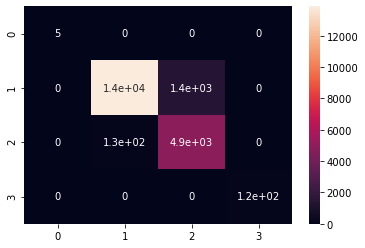

In [341]:
show_cm(cm_train, labels)

In [342]:
cm_train

array([[    5,     0,     0,     0],
       [    0, 13878,  1396,     0],
       [    0,   130,  4852,     0],
       [    0,     0,     0,   124]], dtype=int64)

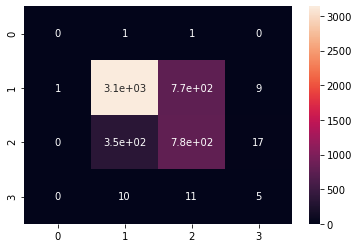

In [343]:
show_cm(cm_test, labels)

In [344]:
cm_test

array([[   0,    1,    1,    0],
       [   1, 3139,  771,    9],
       [   0,  353,  779,   17],
       [   0,   10,   11,    5]], dtype=int64)

La matrice de confusion nous montrent que certaines données on été bien prédite mais qu'il reste pas mal de fausses gravités (faux positif)

# Courbe de ROC

In [345]:
n_classes = Y.nunique()
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_te, pred_prob[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [346]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_te.ravel(), pred_prob[:, i].ravel(),pos_label=1)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

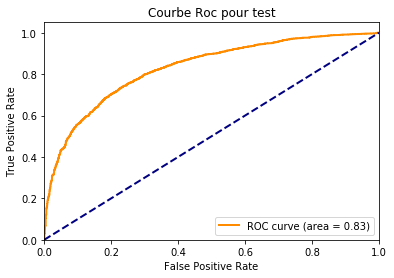

In [347]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe Roc pour test')
plt.legend(loc="lower right")
plt.show()

In [348]:
n_classes = Y.nunique()
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_tr, pred_probtr[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [349]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_tr.ravel(), pred_probtr[:, i].ravel(),pos_label=1)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

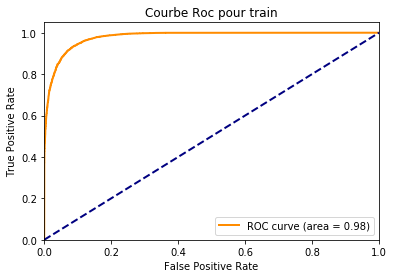

In [350]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe Roc pour train')
plt.legend(loc="lower right")
plt.show()

D'après les diagrammes ci-dessus, la courbe ROC pour les tests et pour les trains sont assez différentes. L'air sous la courbe de la courbe de ROC du train étant bien supérieur à celle de la courbe de ROC du test, il y donc pas de l'Overfitting.